All of the deployment information can be found from our deployment API

In [1]:
import requests

glider_deployments_url = 'http://data.ioos.us/gliders/providers/api/deployment'

response = requests.get(glider_deployments_url)

response.status_code

200

GliderDAC just returns deployment information, it doesn't actually have a GIS search engine or anything fancy like that.

Here we can use Shapely to filter deployments based on a search box

In [2]:
from shapely.geometry import LineString


def parse_geometry(geometry):
    """
    Filters out potentially bad coordinate pairs as returned from
    GliderDAC. Returns a safe geometry object.

    :param dict geometry: A GeoJSON Geometry object
    """
    
    coords = []
    for lon, lat in geometry['coordinates']:
        if lon is None or lat is None:
            continue
        coords.append([lon, lat])
    return {'coordinates': coords}


def fetch_trajectory(deployment):
    """
    Downloads the track as GeoJSON from GliderDAC

    :param dict deployment: The deployment object as returned from GliderDAC
    """
    
    track_url = 'http://data.ioos.us/gliders/status/api/track/' + deployment['deployment_dir']
    response = requests.get(track_url)
    if response.status_code != 200:
        raise IOError("Failed to get Glider Track for %s" % deployment['deployment_dir'])
    geometry = parse_geometry(response.json())
    coords = LineString(geometry['coordinates'])
    return coords

In [3]:
bbox = [
    [-125.72, 32.60],
    [-117.57, 36.93]
]

In [4]:
res = response.json()

In [5]:
print('Found {0} deployments!'.format(res['num_results']))

Found 190 deployments!


In [6]:
deployments = res['results']

In [11]:
deployment = deployments[0]

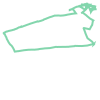

In [12]:
fetch_trajectory(deployment)

In [13]:
deployment['glider_name']

'unit_236'

In [14]:
'http://data.ioos.us/gliders/status/api/track/' + deployment['deployment_dir']

'http://data.ioos.us/gliders/status/api/track/rmiller/unit_236-20121005T2349'

In [15]:
from shapely.geometry import box

search_box = box(bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1])

for deployment in response.json()['results']:
    try:
        coords = fetch_trajectory(deployment)
    except IOError:
        continue
    if search_box.intersects(coords):
        print(deployment['deployment_dir'])

drudnick/sp025-20150108T1921
drudnick/sp030-20150109T2113
drudnick/sp039-20150122T1750
drudnick/sp048-20150127T1824
drudnick/sp035-20150331T1646
drudnick/sp040-20150409T1841
drudnick/sp030-20150714T1840
drudnick/sp028-20150716T2019
drudnick/sp052-20150728T1703
drudnick/sp025-20150813T1746
drudnick/sp011-20150427T1749
drudnick/sp047-20150827T1720
drudnick/sp011-20151105T1727
drudnick/sp064-20151030T1759
drudnick/sp028-20151124T1741
drudnick/sp063-20160203T1915
drudnick/sp030-20160218T1746
drudnick/sp039-20160218T1748
drudnick/sp025-20160310T1858
drudnick/sp054-20160317T1738
drudnick/sp049-20160405T1844
drudnick/sp064-20160517T1813
drudnick/sp011-20160602T1624
drudnick/sp028-20160628T1737
rutgers/ru22-20140804T1632
rutgers/ru22-20140825T1505
drudnick/sp011-20140501T0000
drudnick/sp025-20140611T184300
drudnick/sp028-20140605T170300
drudnick/sp048-20140116T181300
drudnick/sp047-20140623T2230
drudnick/sp030-20140813T1713
drudnick/sp052-20140814T1805
drudnick/sp063-20140915T1905
drudnick/sp0

Those are all of the deployments that intersect that box

<br>
Right click and choose Save link as... to
[download](https://raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-12-20-searching_glider_deployments.ipynb)
this notebook, or see a static view [here](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-12-20-searching_glider_deployments.ipynb).